# 串起来：让机器人可以简单地玩游戏


In [1]:
from CyClient import *
import time
import numpy as np
from matchUtil import *
from Cut import *
import matplotlib.pyplot as plt
from findTemplate import *
cli = Client()
cli.sayHello()

received:     Hello From Server 


In [2]:
cli.takAction(4,0,0)
time.sleep(0.5)
cli.takAction(3,0,0)

received:     M         4         0         0
received:     M         3         0         0


## test

received: 
600 800 3
30000


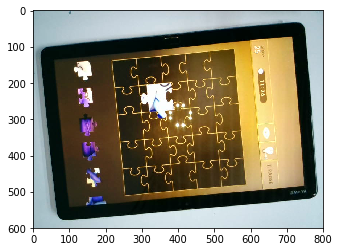

-5.332159519195557


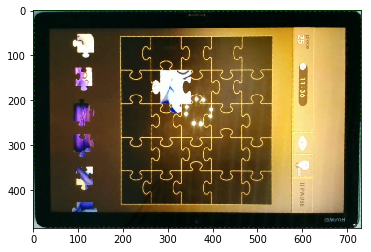

In [40]:
test = cli.getPic()
plt.imshow(test)
plt.show()
cut = get_Contour(test)
plt.imshow(cut)
plt.show()

In [41]:
from matchUtil import *

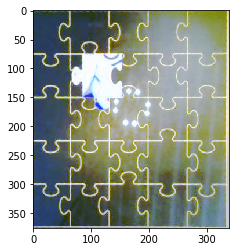

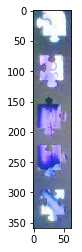

[1, 67]


In [42]:
sor = cutout_source(cut,cut)
plt.imshow(sor)
plt.show()  
#s_x = int(sor.shape[0]/5)
#s_y = int(sor.shape[1]/5)
    
temp_area = cutout_template_area(cut,cut)
plt.imshow(temp_area)
plt.show()
temp_pos = []
temp = cutout_template(cut,cut,temp_pos)
#temp_pos
plt.imshow(temp)
print(temp_pos)

In [70]:
img = ply.getOneShot()
plt.imsave("fullEmpty.png",img)

received: 
600 800 3
30000
-0.0


In [18]:
template = cut
print(temp_pos)
imgshape = template.shape
print(imgshape)
#PHONESIZE = (155,235)
diviceShape = (155,235)
temp_pos_1 = (temp_pos[0]+20 + template.shape[1]*0.114 , temp_pos[1] +25+ template.shape[0]*0.111)
print(temp_pos_1)
x,y =temp_pos_1
#1,0,0,1
x =  (1-x/imgshape[1]) * diviceShape[1] # because x is converted
y =  y/imgshape[0] * diviceShape[0]
print(x+10,y+10)

[6, 10]
(505, 735, 3)
(109.79, 91.055)
209.89707482993197 37.94757425742574


In [58]:
x,y = temp_pos_1
(1-x/imgshape[1])*

0.8352455418381344

In [14]:
cli.takAction(1,int(x),int(y))

received:     M         1         1 2 5         1 3 7


In [52]:
cli.takAction(1,110,210)

received:     M         1         1 1 0         2 1 0


received: 
600 800 3
30000
0.367279052734375


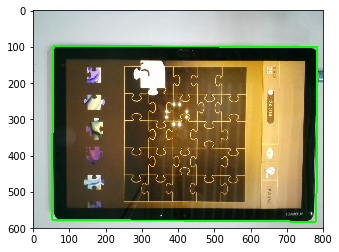

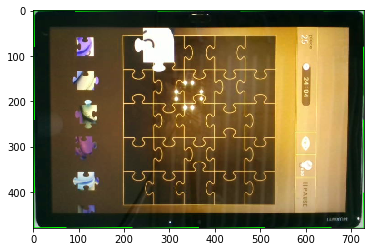

In [60]:
test = cli.getPic()
#plt.imshow(test)
#cv2.imwrite
cut = get_Contour(test)
plt.imshow(test)
plt.show()
#cv2.imwrite("cut_pad.png",cut)
plt.imshow(cut)
plt.show()

# calibration

In [26]:
cli.takAction(1,10,10)

received:     M         1         1 0         1 0


In [27]:
cli.takAction(1,170,10)

received:     M         1         1 7 0         1 0


In [28]:
cli.takAction(1,10,255)

received:     M         1         1 0         2 5 5


In [22]:
cli.getPos() # left upper corner  it is 85, 10, 0, right bottom corner is 15 -135 
'''
base
base = 10 10
pad:left upper corner is 165,10 ,right bottom corner is 15,245,
'''


received: 
(10.0, 245.0, 0)


'\nbase\nbase = 10 10\npad:left upper corner is 165,10 ,right bottom corner is 15,245,\n'

In [8]:
# PHONESIZE = (150,235)
PHONESIZE = (160,245)


In [30]:
class Player:
    def __init__(self,cli):
        self.cli = cli
        self.basePoint = np.array([0,0])
        self.sourceimg = None # the image of the jagsaw to recover
        self.emptyimg = None # the image of the empty target area 
    def setBase(self):
        # move to where 0,0 point should be in the figure
        curr = self.cli.getPos()
        print("current position: ", curr[:2])
        self.basePoint = np.array(curr[:2])
    def moveto(self,x,y):
        x += self.basePoint[0]
        y += self.basePoint[1]
        x,y = int(x),int(y)
        cx,cy,_  =self.cli.getPos()
        self.cli.takAction(1,x,y)
         # getPos can not get the current pos, but the target pos
        # the time is 2.76s to move from -10,-10 to 100,100
        speed = 56
        dist = ((x-cx)**2+(y-cy)**2)**(1/2)
        waittime = dist/speed + 0.5
        time.sleep(waittime)
        
        
    def movetoImg(self,x,y,imgshape,diviceShape = PHONESIZE):
        # imgshape is (y_shape, x_shape)
        '''
        x =  (1-x/imgshape[1]) * diviceShape[0] # because x is converted
        y =  y/imgshape[0] * diviceShape[1]
        '''
        x =  (1-x/imgshape[1]) * diviceShape[1] # because x is converted
        y =  y/imgshape[0] * diviceShape[0]
        x,y = y,x
        self.moveto(x,y)
    
    def retreat(self):
        #self.moveto(-10,-10)
        self.moveto(-10,-10)
#         self.cli.takAction(3,0,0)
    
    def clickAtImg(self, x, y,imgshape,diviceShape = PHONESIZE):
        print(imgshape,diviceShape)
        self.movetoImg(x, y,imgshape,diviceShape)
#         time.sleep(2)
#         self.cli.takAction(2,0,0)
        self.cli.takAction(4,0,0)
        time.sleep(0.5)
        self.cli.takAction(3,0,0)
        self.retreat()
    
    def dragAtImg(self, x0,y0,x1,y1,imgshape,diviceShape = PHONESIZE,roundAbout = None):
        self.movetoImg(x0,y0,imgshape,diviceShape)
        self.cli.takAction(4,0,0)
        time.sleep(0.2)
        if(roundAbout is not None):
            x2,y2 = roundAbout
            self.movetoImg(x2,y2,imgshape,diviceShape)
        self.movetoImg(x1,y1,imgshape,diviceShape)
        self.cli.takAction(3,0,0)
    
    def tryOneDrag(self,x0,y0,x1,y1,imgshape,diviceShape = PHONESIZE, shot = False, back = True, roundAbout = None):
        # drag the piece to the position and then drag it back
        # if it is the correct piece it will stay there
#         targetShape = 
        # roundAbout is the point first drag to
        sx = int(imgshape[1]*(0.735-0.273)/10) # the shift amount
        sy = int(imgshape[0]*(0.895-0.120)/10)
        self.dragAtImg(x0,y0,x1-sx,y1+sy,imgshape,diviceShape = PHONESIZE,roundAbout)
        if(shot):
            self.retreat()
            img = self.getOneShot()
            if(not back):
                return img
        else:
            time.sleep(2)
        #self.dragAtImg(x1,y1+30,x0,y0-30,imgshape,diviceShape = PHONESIZE)
        self.dragAtImg(x1+sx,y1+sy,x0-2*sx,y0,imgshape,diviceShape = PHONESIZE) # Note the x,y = y,x in movetoImg
        self.retreat()
        if(shot):
            return img
        
    def getOneShot(self):
        img = self.cli.getPic()
        img = get_Contour(img)
        return img
    
    def initGame(self):
        # The phone should be before the game start
        self.retreat()
        img = self.getOneShot()
        #source ?
        self.sourceimg = img
        y,x = img.shape[:2]
        #x,y = x*0.502,y*0.237
        x,y = x*0.4,y*0.16
        self.clickAtImg(x,y,img.shape[:2])
        img = self.getOneShot()
        self.emptyimg = cutout_target(img)
        plt.imshow(self.sourceimg)
        plt.show()
        plt.imshow(self.emptyimg)
        plt.show()
               
        
        
ply = Player(cli)

In [29]:
cli.takAction(1,10,10)

received:     M         1         1 0         1 0


In [31]:
ply.setBase()

received: 
(10.0, 10.0, 0)
current position:  (10.0, 10.0)


In [32]:
ply.retreat()

received: 
(10.0, 10.0, 0)
received:     M         1         0         0


received: 
(0.0, 0.0, 0)
received:     M         1         0         0
received: 
600 800 3
30000
-5.572198390960693
(484, 730) (160, 245)
received: 
(0.0, 0.0, 0)
received:     M         1         3 5         1 5 7
received:     M         4         0         0
received:     M         3         0         0
received: 
(35.0, 157.0, 0)
received:     M         1         0         0
received: 
600 800 3
30000
-5.3977484703063965


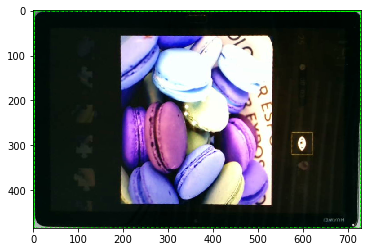

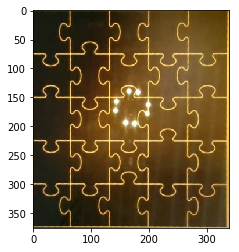

In [33]:
ply.initGame()

In [35]:
#ply.tryOneDrag(100,40, 300,100,ply.sourceimg.shape[:2])
ply.tryOneDrag(430,440, 420,200,ply.sourceimg.shape[:2])
#cli.takAction(1,45,10)

AttributeError: 'NoneType' object has no attribute 'shape'

In [ ]:
ply.sourceimg.shape[:2]

received:     M         1         3 5         0


In [47]:
from matchUtil import *

In [45]:
# ply.movetoImg(82.878+20,203.391+30,(481,727)) # the +20 and +30 here is to assemble the effect in tryOneDrag
ply.movetoImg(150,85,(481,727)) # the +20 and +30 here is to assemble the effect in tryOneDrag

received: 
(35.0, 196.0, 1)
received:     M         1         3 6         1 9 6


In [121]:
cli.takAction(3,0,0)

received:     M         3         0         0


In [22]:
ply.retreat()

received: 
(60.0, 55.0, 0)
received:     M         1         0         0


In [34]:
def DragToCorner(ply,tempPos = None):
    img = ply.getOneShot()
    target = cutout_target(img)
    if(tempPos is None):
        tempPos = []
        _ = cutout_template(None,img.copy(),tempPos)
        x0,y0 = (tempPos[0] + img.shape[1]*0.114 , tempPos[1] + img.shape[0]*0.111)
    else:
        x0,y0 = tempPos
#     (x0,y0), _= matching(ply.sourceimg,img.copy(),mode = "match",debug = True)
    # shift from the corner to the middle of the template
    x0,y0 = x0+10+20, y0+30
    
    x,y = int(img.shape[1]*0.273), int(img.shape[0]*0.120)
    print("tryOneDrag:",x0,y0,x,y,img.shape[:2])
    return ply.tryOneDrag(x0,y0,x,y,img.shape[:2],shot = True,back = False,roundAbout = (x+20,y0))
    
# img = DragToCorner(ply)

In [42]:
# ply.movetoImg(180+20,57+40, [479,730])
# cli.takAction(4,0,0)
ply.movetoImg(199,57, [479,730])

# ply.retreat()

received: 
(41.0, 204.0, 1)
received:     M         1         4 3         2 0 4


In [35]:
def dragToGrid(ply,x0,y0,x1,y1,sor_shape,img_shape,shot,back = True):
    """
    x,y is the cordinate of the source area 0...4
    """
    x0 = int(x0*sor_shape[1]/5 + img_shape[1]*0.273 + sor_shape[1]/10)
    y0 = int(y0*sor_shape[0]/5 + img_shape[0]*0.120 + sor_shape[0]/10)
    x1 = int(x1*sor_shape[1]/5) + int(img_shape[1]*0.273)
    y1 = int(y1*sor_shape[0]/5) + int(img_shape[0]*0.120)
    # to get to the middle of the template
#     x0,y0 = x0 +34, y0+37 # sor_shape[1]/10
    
    print("ply.tryOneDrag",x0,y0,x1,y1,img_shape[:2],shot)
    return ply.tryOneDrag(x0,y0,x1,y1,img_shape[:2],shot,back)

# img = ply.getOneShot()
# sor = cutout_target(img)
# plt.imshow(sor)
# plt.show()
# dragToGrid(ply,2,2,0,0,sor.shape[:2],img.shape[:2],False)
# dragToGrid(ply,0,0,2,4,sor.shape[:2],img.shape[:2],False)

In [117]:
sor.shape

(373, 337, 3)

In [119]:
ply.movetoImg(233-34-35,94-37+37, [481,729])

received: 
(41.0, 206.0, 1)
received:     M         1         4 1         1 9 9


In [37]:
ply.retreat()

received: 
(132.0, 110.0, 0)
received:     M         1         0         0


In [116]:
cli.takAction(4,0,0)

received:     M         4         0         0


received: 
600 800 3
30000
-5.19442892074585


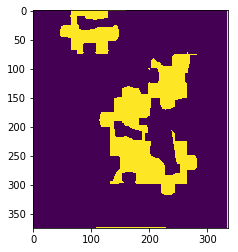

[[2.58298507e+01 1.72131343e+02 1.82179104e+01 1.01492537e-01
  5.07462687e-01]
 [0.00000000e+00 1.62388060e+00 3.36955224e+01 1.91922388e+02
  7.00298507e+00]
 [0.00000000e+00 2.66417910e+01 1.78474627e+02 3.47104478e+01
  3.80597015e+00]
 [0.00000000e+00 1.52238806e+00 2.02071642e+02 1.47722388e+02
  2.24805970e+01]
 [0.00000000e+00 1.31940299e+00 3.40000000e+00 2.22268657e+01
  3.80597015e+00]]
received: 
600 800 3
30000
-5.31454610824585
tryOneDrag: 113.10600000000001 132.613 199 57 (483, 729)
received: 
(0.0, 0.0, 0)
received:     M         1         5 3         2 1 6
received:     M         4         0         0
received: 
(53.0, 216.0, 1)
received:     M         1         4 1         1 9 9
received:     M         3         0         0
received: 
(41.0, 199.0, 0)
received:     M         1         0         0
received: 
600 800 3
30000
-5.355824947357178


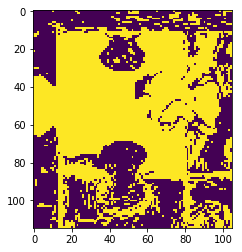

possible: [[ True False  True  True  True]
 [ True  True  True False  True]
 [ True  True False  True  True]
 [ True  True False False  True]
 [ True  True  True  True  True]]
scores: [[34769952.    13492797.    13884545.    16031259.    62870688.   ]
 [ 2440126.75  14700726.    26026268.    28059450.    54978604.   ]
 [13706969.    17133324.    15997334.    64151824.    58573360.   ]
 [ 1147881.125 24888792.    34360004.    26772994.    53390848.   ]
 [24431566.    48667972.    35430792.    40742176.    56004548.   ]]
DRAG TO:  3 2
ply.tryOneDrag 232 95 400 207 (483, 729) True
received: 
(0.0, 0.0, 0)
received:     M         1         4 1         1 7 7
received:     M         4         0         0
received: 
(41.0, 177.0, 1)
received:     M         1         9 0         1 3 1
received:     M         3         0         0
received: 
(90.0, 131.0, 0)
received:     M         1         0         0
received: 
600 800 3
30000
-5.19442892074585
received: 
(0.0, 

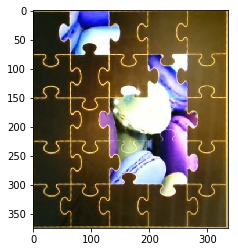

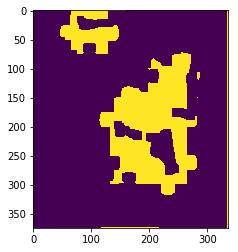

[[ 27.91044776 172.68955224  18.16716418   0.8119403    1.06567164]
 [  0.           1.6238806   36.74029851 195.77910448  11.31641791]
 [  0.          26.69253731 195.11940299 192.63283582  13.34626866]
 [  0.           1.97910448 204.35522388 152.0358209   22.48059701]
 [  0.           0.86268657   3.4         21.61791045   3.80597015]]
TRIED: 1


In [50]:
def playOneStep(ply):
    img = ply.getOneShot() # whole screen before move
    target = cutout_target(img.copy())
    
#     (x0,y0), scores = old_matching(ply.sourceimg.copy(),img.copy(),mode = "match",debug = True)
#     print("Template: ",x0,y0,"img shape: ", img.shape[:2])
    #应该还需要10-20的调整
    #为什么有时候会出现不停止直接走然后图像出现异常的情况
    possible = findEmpty(ply.emptyimg,target,mode = "debug")
    moved_template = DragToCorner(ply) # screen after the template is moved to corner
    
    template = find_template(moved_template,img)
#     plt.imshow(template)
#     plt.show()
#     plt.imshow(ply.sourceimg)
#     plt.show()
    source = cutout_target(ply.sourceimg)
    global tmpcount
    cv2.imwrite("tmpTemplate%d.png"%tmpcount,template)
    cv2.imwrite("tmpSource%d.png"%tmpcount,source)
    tmpcount += 1
    scores = matching(source,template)
#     print("Rx,RY",rx,ry)
#     rx,ry = min(4,rx),min(4,ry)
#     rx,ry = int(rx),int(ry)
#     scores = matching(ply.sourceimg,moved_template,img,mode = "match",debug = True)
#     scores[ry][rx] = 99999999
    initial_num = possible.sum()
    print("possible:", possible)
    print("scores:",scores)
    triedCount = 0
#     return 
    while(possible.sum()>0):
        y = np.argmax(scores)//5 # x => i 
        x = np.argmax(scores)%5
        print("DRAG TO: ",x,y)
        scores[y][x]=-1
        if(not possible[y][x] or (x==0 and y==0)): # we don't have to move to 0,0, we just check it in the next round
            continue
        possible[y][x] = False
        
#         print("Tries To Drag:",x0,y0,x,y)
        if(not triedCount and possible[0][0] ): # the first try to drag, check whether is 0,0 here
            newimg = dragToGrid(ply, 0,0,x,y,target.shape[:2],img.shape[:2],shot=True, back = True)
            newimg = cutout_target(newimg)
            newempty = findEmpty(ply.emptyimg,newimg,mode = "release")
            if(not newempty[0][0]): # the template stayes at the pos 0,0
                break
        else:
            dragToGrid(ply,0,0,x,y,target.shape[:2],img.shape[:2],shot=False, back = True)
        triedCount += 1
        
        time.sleep(3)
        
        timg = ply.getOneShot()
        timg = cutout_target(timg)
        
        plt.imshow(timg)
        plt.show()
        empty = findEmpty(ply.emptyimg,timg,mode = "debug")
        print("TRIED:", triedCount )
        if(not empty[y][x]):
            break
playOneStep(ply)

In [34]:
def templateCenter(x,y):
    """
    input the corner of the template(corner calculated in play_one_step)
    """
    return x+20,y+30

received: 
600 800 3
30000
-4.594253063201904


ZeroDivisionError: division by zero

In [38]:
tmpcount = 0

In [108]:
img = ply.getOneShot()
cv2.imwrite("tmp.png",img)



received: 
600 800 3
30000
-1.9349322319030762


True

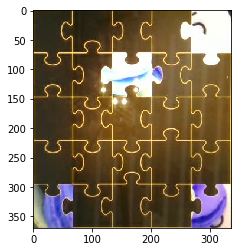

(370, 337, 3)


In [92]:
# ply.movetoImg(197,54,img.shape[:2])
# ply.movetoImg(532,427,img.shape[:2])
sor = cutout_target(img)

plt.imshow(sor)
plt.show()
print(sor.shape)